### Mouting Drive

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

### Setting up

In [60]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
display.display(tf.test.gpu_device_name())
pd.options.display.max_rows = 10
pd.set_option('display.float_format', lambda x: "%.1f" % x)
style.use('ggplot')

'/device:GPU:0'

### Load Dataset and Randomization

In [87]:
crabs_dataframe = pd.read_csv("drive/ml_directory/crabs_model/crabs_dataset.txt",
                              delim_whitespace=True)
crabs_dataframe = crabs_dataframe.reindex(
    np.random.permutation(crabs_dataframe.index))
crabs_dataframe.head(10)

,sp,sex,index,FL,RW,CL,CW,BD
150,O,F,1,10.7,9.7,21.4,24.0,9.8
135,O,M,36,18.6,13.5,36.9,40.2,17.0
92,B,F,43,15.7,13.9,33.6,38.5,14.1
14,B,M,15,12.8,10.9,27.4,31.5,11.0
96,B,F,47,16.7,16.1,36.6,41.9,15.4
90,B,F,41,15.6,13.9,32.8,37.9,13.4
134,O,M,35,18.6,13.4,37.8,41.9,17.3
157,O,F,8,14.3,12.2,28.1,31.8,12.5
156,O,F,7,14.0,12.8,28.8,32.4,12.7
121,O,M,22,15.4,11.1,30.2,33.6,13.5


### Encoding Dataset for convinience

In [88]:
crabs_dataframe_encoded = crabs_dataframe
crabs_dataframe_encoded['sp'] = crabs_dataframe['sp'].apply(
    lambda x: 1 if x == 'B' else 0)
crabs_dataframe_encoded['sex'] = crabs_dataframe['sex'].apply(
    lambda x: 1 if x == 'M' else 0)
crabs_dataframe_encoded.head(10)

,sp,sex,index,FL,RW,CL,CW,BD
150,0,0,1,10.7,9.7,21.4,24.0,9.8
135,0,1,36,18.6,13.5,36.9,40.2,17.0
92,1,0,43,15.7,13.9,33.6,38.5,14.1
14,1,1,15,12.8,10.9,27.4,31.5,11.0
96,1,0,47,16.7,16.1,36.6,41.9,15.4
90,1,0,41,15.6,13.9,32.8,37.9,13.4
134,0,1,35,18.6,13.4,37.8,41.9,17.3
157,0,0,8,14.3,12.2,28.1,31.8,12.5
156,0,0,7,14.0,12.8,28.8,32.4,12.7
121,0,1,22,15.4,11.1,30.2,33.6,13.5


### Preprocess Data

In [0]:
def preprocess_features(crabs_dataframe_encoded):
    selected_features = crabs_dataframe_encoded[['sex','FL','RW','CL','CW','BD']]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(crabs_dataframe_encoded):
    output_targets = pd.DataFrame()
    output_targets['sp'] = crabs_dataframe_encoded['sp']
    return output_targets

### Training set, Validation set and Test set

In [90]:
training_examples = preprocess_features(crabs_dataframe_encoded[:100])
training_targets = preprocess_targets(crabs_dataframe_encoded[:100])
print("Training Examples Summary: ")
display.display(training_examples.describe())
print("Training Targets Summary: ")
display.display(training_targets.describe())

validation_examples = preprocess_features(crabs_dataframe_encoded[100:150])
validation_targets = preprocess_targets(crabs_dataframe_encoded[100:150])
print("Validation Examples Summary: ")
display.display(validation_examples.describe())
print("Validation Targets Summary: ")
display.display(validation_targets.describe())

test_examples = preprocess_features(crabs_dataframe_encoded[150:])
test_targets = preprocess_targets(crabs_dataframe_encoded[150:])
print(len(test_examples))
print(len(test_targets))

Training Examples Summary: 


,sex,FL,RW,CL,CW,BD
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,0.4,15.5,12.8,31.8,36.1,13.8
std,0.5,3.5,2.6,7.0,7.7,3.4
min,0.0,7.2,6.5,14.7,17.1,6.1
25%,0.0,12.8,11.1,27.6,31.8,11.3
50%,0.0,15.4,12.9,31.7,36.0,13.8
75%,1.0,18.2,14.2,36.8,41.9,16.4
max,1.0,23.1,20.2,47.2,52.5,21.5


Training Targets Summary: 


,sp
count,100.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


Validation Examples Summary: 


,sex,FL,RW,CL,CW,BD
count,50.0,50.0,50.0,50.0,50.0,50.0
mean,0.6,15.7,12.6,32.3,36.5,14.3
std,0.5,3.6,2.6,7.5,8.2,3.6
min,0.0,8.1,6.7,16.1,19.0,7.0
25%,0.0,13.0,10.7,26.9,30.5,11.9
50%,1.0,16.2,12.8,32.7,37.0,14.6
75%,1.0,18.3,14.2,38.1,43.2,17.1
max,1.0,22.5,18.0,45.7,49.7,20.9


Validation Targets Summary: 


,sp
count,50.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


50
50


### Construct Feature Columns

In [0]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
                for my_feature in input_features])

### Input Function

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Neural Network Model

In [0]:
def train_nn_classification_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods

    # Create and configure dnn_classifier object
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns = construct_feature_columns(training_examples),
        hidden_units = hidden_units,
        optimizer = my_optimizer
    )

    # Create input_fn
    training_input_fn = lambda: my_input_fn(
        training_examples, training_targets['sp'], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, training_targets['sp'], shuffle=False, num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, validation_targets['sp'], shuffle=False, num_epochs=1)

    # Train the model in a loop
    print("Training model...")
    print("  LogLoss error (on training data & validation data): ")
    training_log_losses = []
    validation_log_losses = []
    for period in range(0, periods):
        dnn_classifier.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )

        # Compute predictions
        training_predictions = list(dnn_classifier.predict(
            input_fn=predict_training_input_fn))
        training_probabilities = np.array(
            [item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array(
            [item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(
            training_pred_class_id, 2)

        validation_predictions = list(dnn_classifier.predict(
            input_fn=predict_validation_input_fn))
        validation_probabilities = np.array(
            [item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array(
            [item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(
            validation_pred_class_id, 2)

        # Compute log_loss
        training_log_loss = metrics.log_loss(
            training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(
            validation_targets, validation_pred_one_hot)
        print("    Period %02d : %0.2f\t%0.2f" % 
              (period, training_log_loss, validation_log_loss))
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
    print("Final LogLoss (on training data): %0.5f" % training_log_loss)
    print("Final LogLoss (on validation data) : %0.5f" % validation_log_loss)

    final_training_predictions = dnn_classifier.predict(
        input_fn=predict_training_input_fn)
    final_training_predictions = np.array(
        [item['class_ids'][0] for item in final_training_predictions])

    final_validation_predictions = dnn_classifier.predict(
        input_fn=predict_validation_input_fn)
    final_validation_predictions = np.array(
        [item['class_ids'][0] for item in final_validation_predictions])

    # Compute accuracy
    training_accuracy = metrics.accuracy_score(
        training_targets, final_training_predictions)
    validation_accuracy = metrics.accuracy_score(
        validation_targets, final_validation_predictions)

    print("Accuracy (on training data): %0.5f" % training_accuracy)
    print("Accuracy (on validation data): %0.5f" % validation_accuracy)

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training", color="magenta")
    plt.plot(validation_log_losses, label="validation", color="g")
    plt.legend()
    plt.show()

    cm = metrics.confusion_matrix(validation_targets,final_validation_predictions)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix (validation)")
    plt.ylabel("True label")
    plt.xlabel("Prediction label")
    plt.show()
    return dnn_classifier

Training model...
  LogLoss error (on training data & validation data): 
    Period 00 : 18.31	13.82
    Period 01 : 18.31	13.82
    Period 02 : 18.31	13.82
    Period 03 : 18.31	13.82
    Period 04 : 18.31	13.82
    Period 05 : 18.31	13.82
    Period 06 : 18.31	13.82
    Period 07 : 18.31	13.82
    Period 08 : 18.31	13.82
    Period 09 : 18.31	13.82
Model training finished.
Final LogLoss (on training data): 18.30555
Final LogLoss (on validation data) : 13.81551
Accuracy (on training data): 0.47000
Accuracy (on validation data): 0.60000


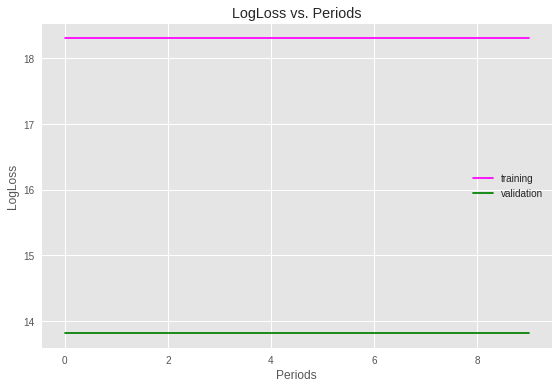

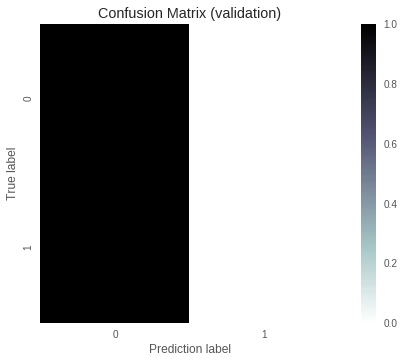

In [94]:
dnn_classifier = train_nn_classification_model(
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000021),
    steps = 1000,
    batch_size = 300,
    hidden_units = [5, 4],
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

In [98]:
predict_test_input_fn = lambda: my_input_fn(
    test_examples, test_targets['sp'], shuffle=False, num_epochs=1)

test_predictions = list(dnn_classifier.predict(input_fn=predict_test_input_fn))
test_probabilities = np.array(
    [item['probabilities'] for item in test_predictions])
test_pred_class_id = np.array(
    [item['class_ids'][0] for item in test_predictions])
test_pred_one_hot = tf.keras.utils.to_categorical(test_pred_class_id, 2)

test_log_loss = metrics.log_loss(test_targets, test_pred_one_hot)
print("LoggLoss (on testing data): %0.5f" % test_log_loss)

final_test_predictions = dnn_classifier.predict(input_fn=predict_test_input_fn)
final_test_predictions = np.array(
    [item['class_ids'][0] for item in final_test_predictions])

test_accuracy = metrics.accuracy_score(test_targets, final_test_predictions)
print("Accuracy (on test data): %0.5f" % test_accuracy)

LoggLoss (on testing data): 18.65094
Accuracy (on test data): 0.46000
